<a href="https://colab.research.google.com/github/Omid-Hassasfar/CHPC2024-QuantumComputing/blob/main/CHPC_2024_QC_SpinSystemSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors of main paper : Jarrett L. Lancaster and D. Brysen Allen. (https://github.com/jllancas)

Adaptation for the CHPC 2024 Workshop by Abbas (Omid) Hassasfar.

In [ ]:
!pip install qiskit[visualization] --quiet  # Install Qiskit with visualization support
!pip install qiskit-ibm-runtime --quiet     # Install Qiskit IBM Runtime for accessing IBM Quantum services
!pip install qiskit-aer --quiet             # Install Qiskit Aer for high-performance quantum simulations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 33.4 MB/s eta 0:00:00


## Importing Packages!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import scipy as sp

import qiskit
import qiskit_ibm_runtime
import qiskit_aer
import matplotlib

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit Aer: {qiskit_aer.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print()
print("Numpy version:", np.__version__)
print("Scipy version:", sp.__version__)
print("Sympy version:", sp.__version__)
print("Matplotlib version:", matplotlib.__version__)
print()
!python --version

Qiskit: 1.3.0
Qiskit Aer: 0.15.1
Qiskit IBM Runtime: 0.33.2

Numpy version: 1.26.4
Scipy version: 1.13.1
Sympy version: 1.13.1
Matplotlib version: 3.8.0

Python 3.10.12


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

from qiskit.circuit import Parameter

from qiskit.primitives import StatevectorSampler, StatevectorEstimator, Sampler, Estimator

from qiskit.result import marginal_distribution

from qiskit.providers.basic_provider import BasicProvider

from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere, plot_state_city

from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, concurrence

from qiskit.circuit.library import PauliEvolutionGate, UGate, QFT

from qiskit_aer import AerSimulator, StatevectorSimulator, UnitarySimulator

from math import pi, cos, sin

from random import randrange

https://github.com/Omid-Hassasfar/qiskit-tutorial-Archive/blob/master/tutorials/circuits/3_summary_of_quantum_operations.ipynb

https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.UGate

In this notebook, we explore the simulation of time evolution in single spin systems. For a quantum state $\left|\psi\right\rangle$, time evolution is governed by the Schrödinger equation,

$$i\hbar \frac{d}{dt}\left|\psi\right\rangle = \hat{H}\left|\psi\right\rangle.$$

For now, we'll assume a time-independent Hamiltonian. In particular, the relevant Hamiltonian for a spin in a constant magnetic field ${\bf B}$ is

$$\hat{H} = -\mu {\bf B}\cdot\hat{\bf S},$$

where $\lambda$ is some constant proportional to the magnetic moment of the spin and $\hat{\bf S} = \hat{S}^{x}\hat{\bf x} +  \hat{S}^{y}\hat{\bf y} + \hat{S}^{z}\hat{\bf z}$.

As an example, let's suppose $\left|\psi(0)\right\rangle = \left|+\right\rangle$ and ${\bf B} = B_{0}\hat{y}$ for some constant $B_{0}$. Here we follow  convention $\hat{S}^{z}|0\rangle = \frac{\hbar}{2}|0\rangle$ for spin states which are represented by qubits as $|+\rangle\rightarrow |0\rangle$, $|-\rangle \rightarrow |1\rangle$. Note Qiskit resources employ the alternate convention of defining superposition states $|\pm\rangle \equiv \frac{1}{\sqrt{2}}\left(|0\rangle \pm |1\rangle\right)$, which is <b>not</b> the case here. We take $|\pm\rangle$ to stand for the eigenstates of $\hat{S}^{z}$ and represent them by the computational basis kets, $\left\{|0\rangle, |1\rangle\right\}$. For this case, the Hamiltonian simplifies to

$$\hat{H} \rightarrow -\frac{\mu B_{0}\hbar}{2}\sigma^{y} \;\;\dot{=}\;\; -\hbar\omega\left(\begin{array}{cc} 0 & -i\\ i & 0\end{array}\right),$$

where $\omega \equiv \mu B_{0}$. The fundamental problem in quantum dynamics is to predict the probabilities of measurement outcomes or expectation values at some time $t$ given a Hamiltonian $\hat{H}$ and an initial state for the system, $\left|\psi(0)\right\rangle$. We first consider this simple example for which it is straightforward to solve the Schrödinger equation exactly. A formal integration gives

$$\left|\psi(t)\right\rangle = e^{-i\hat{H}t/\hbar}\left|\psi(0)\right\rangle$$,

where

$$e^{-i\hat{H}t/\hbar} = e^{i\frac{\omega t}{2}\sigma^{y}}.$$

We can compute the exponential of a matrix by using the Taylor expansion of the exponential function as a definition.

$$e^{i\frac{\omega t}{2}\sigma^{y}} \equiv \hat{I} + i\frac{\omega t}{2}\sigma^{y} + \frac{\left(i\frac{\omega t}{2}\sigma^{y}\right)^{2}}{2!} + \frac{\left(i\frac{\omega t}{2}\sigma^{y}\right)^{3}}{3!} + \frac{\left(i\frac{\omega t}{2}\sigma^{y}\right)^{4}}{4!} + \cdots.$$

Using $(\sigma^{y})^{2} = \hat{I}$ and $i^{2} = -1$, one may group even and odd terms

$$e^{i\frac{\omega t}{2}\sigma^{y}} = \hat{I}\left[1 - \frac{(\omega t/2)^{2}}{2!} + \frac{(\omega t/2)^{4}}{4!} + \cdots\right] + i\sigma^{y}\left[\omega t - \frac{(\omega t/2)^{3}}{3!} + \frac{(\omega t/2)^{5}}{5!} + \cdots\right].$$

The series in brackets are cosine and sine Taylor expansions, respectively. Writing out $\hat{I}$ and $\sigma^{y}$ as explicit matrices, we get

$$e^{i\omega t/2\sigma^{y}} = \hat{I}\cos(\omega t/2) + i\sigma^{y}\sin(\omega t/2) \;\;\dot{=}\;\; \left(\begin{array}{cc} \cos(\omega t/2) & \sin(\omega t/2)\\ -\sin(\omega t/2) & \cos(\omega t/2)\end{array}\right)$$

Now recall the general $\hat{U}(\theta,\phi,\lambda)$ gate

$$\hat{U}(\theta,\phi,\lambda) \;\;\dot{=} \left(\begin{array}{cc} \cos\frac{\theta}{2} & -e^{i\lambda}\sin\frac{\theta}{2} \\ e^{i\phi}\sin\frac{\theta}{2} & e^{i(\lambda + \phi)}\cos\frac{\theta}{2}\end{array}\right)$$

Then the time evolution is equivalent to the following $\hat{U}$ gate:

$$e^{-i\hat{H}t/\hbar} = \hat{U}(\omega t,\pi,\pi),$$

or $\left|\psi(t)\right\rangle = \hat{U}(\omega t,\pi,\pi)\left|+\right\rangle$. Exponentiating the Hamiltonian explicitly is rarely the most efficient way to solve for time dynamics analytically. See one of the [many](https://www.springer.com/gp/book/9780306447907) [excellent](https://www.pearson.com/us/higher-education/program/Mc-Intyre-Quantum-Mechanics/PGM64990.html) [textbooks](https://www.cambridge.org/highereducation/books/introduction-to-quantum-mechanics/990799CA07A83FC5312402AF6860311E#overview) on QM for the standard approach. But this approach does lend itself to an efficient quantum circuit design for calculating spin dynamics.

Lastly, we note that in the manuscript $\hat{H} = \mu\hat{S}^{x}$, and it is shown that the time evolution operator becomes

$$|\psi(t)\rangle = \hat{U}\left(\omega t, \frac{\pi}{2},-\frac{\pi}{2}\right)|\psi(0)\rangle$$

This is the case we will consider below.

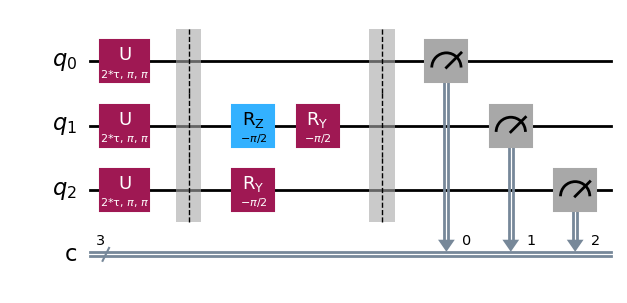

In [ ]:
tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc = QuantumCircuit(qr,cr)

#no initial unitary transformation since |ψ(0)> = |0>

timecirc.u(2*tau,np.pi,np.pi,qr) #apply exp(-iHt/ħ)
timecirc.barrier(qr)
timecirc.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc.rz(-np.pi/2,1)
timecirc.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc.barrier(qr)
#no rotation needed to measure <Sz>

timecirc.measure(qr,cr)
timecirc.draw('mpl')

In [ ]:
tau_range = np.linspace(0, 2*np.pi, Nt)

sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc, tau_range)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

In [ ]:
Sx = np.zeros(Nt)
Sy = np.zeros(Nt)
Sz = np.zeros(Nt)

for n in range(0,Nt):
    simcounts = result.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sx[n] = Sx[n] + 0.5*simcounts[state]/nshots
        else:
            Sx[n] = Sx[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sy[n] = Sy[n] + 0.5*simcounts[state]/nshots
        else:
            Sy[n] = Sy[n] - 0.5*simcounts[state]/nshots

        if (state[2]=='0'):
            Sz[n] = Sz[n] + 0.5*simcounts[state]/nshots
        else:
            Sz[n] = Sz[n] - 0.5*simcounts[state]/nshots

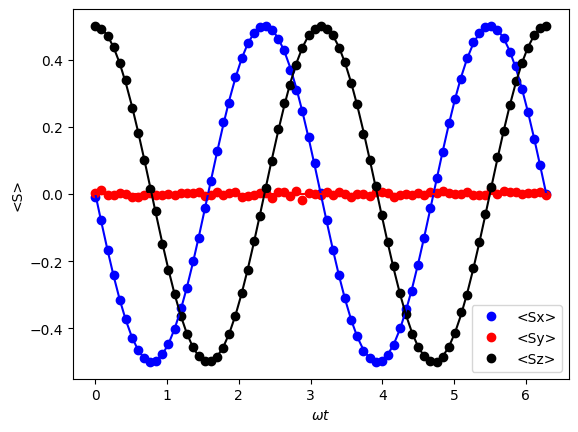

In [ ]:
plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,-0.5*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0*tau_range,'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

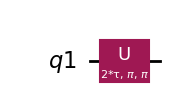

In [ ]:
tau = Parameter('τ')

Nt = 75
qr = QuantumRegister(1)

timecirc2 = QuantumCircuit(qr)

#no initial unitary transformation since |ψ(0)> = |0>

timecirc2.u(2*tau,np.pi,np.pi,qr) #apply exp(-iHt/ħ)

timecirc2.draw('mpl')

In [ ]:
Sx = SparsePauliOp.from_list([("X", 0.5)])
Sy = SparsePauliOp.from_list([("Y", 0.5)])
Sz = SparsePauliOp.from_list([("Z", 0.5)])

In [ ]:
estimator = StatevectorEstimator()

pub = (
    timecirc2,  # circuit
    [[Sx], [Sy], [Sz]],  # Observables
    tau_range,
)

job_result = estimator.run(pubs=[pub]).result()

In [ ]:
sx_est = job_result[0].data.evs[0]
sy_est = job_result[0].data.evs[1]
sz_est = job_result[0].data.evs[2]

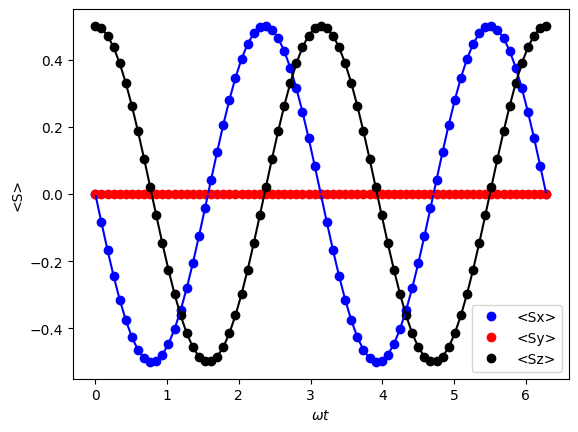

In [ ]:
plt.plot(tau_range,sx_est,'bo',label='<Sx>')
plt.plot(tau_range,sy_est,'ro',label='<Sy>')
plt.plot(tau_range,sz_est,'ko',label='<Sz>')
plt.plot(tau_range,-0.5*np.sin(2*tau_range),'b-')
plt.plot(tau_range,0*tau_range,'r-')
plt.plot(tau_range,0.5*np.cos(2*tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

---
---

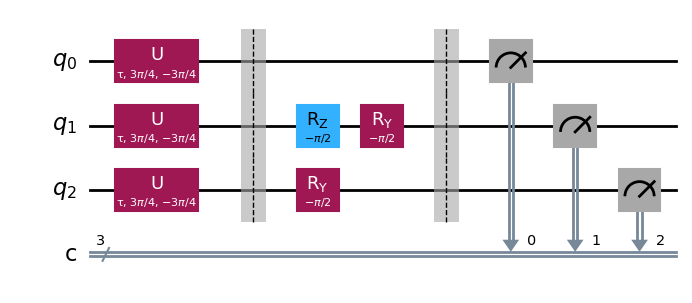

In [ ]:
tau = Parameter('τ')
Nt = 75
qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc = QuantumCircuit(qr,cr)
θ = np.pi/2
ϕ = np.pi/4

timecirc.u(tau,np.pi/2+ϕ,-np.pi/2-ϕ,qr)
timecirc.barrier(qr)
timecirc.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc.rz(-np.pi/2,1)
timecirc.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc.barrier(qr)
#no rotation needed to measure <Sz>

timecirc.measure(qr,cr)
timecirc.draw('mpl')

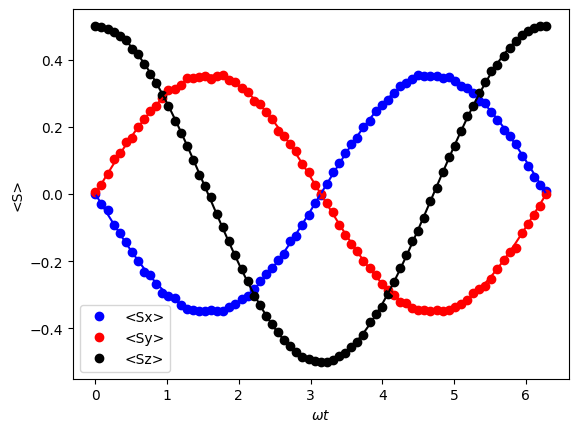

In [ ]:
tau_range = np.linspace(0, 2*np.pi, Nt)

sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc, tau_range)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

Sx = np.zeros(Nt)
Sy = np.zeros(Nt)
Sz = np.zeros(Nt)

for n in range(0,Nt):
    simcounts = result.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sx[n] = Sx[n] + 0.5*simcounts[state]/nshots
        else:
            Sx[n] = Sx[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sy[n] = Sy[n] + 0.5*simcounts[state]/nshots
        else:
            Sy[n] = Sy[n] - 0.5*simcounts[state]/nshots

        if (state[2]=='0'):
            Sz[n] = Sz[n] + 0.5*simcounts[state]/nshots
        else:
            Sz[n] = Sz[n] - 0.5*simcounts[state]/nshots


plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

### Introduction to Trotter steps

For short time steps, we <i>can</i> approximate the full operator by a sequence of noncommuting operators. Taking the full time evolution operator to be of the form $\hat{U} = \exp\left[it(\hat{A}+\hat{B})\right]$ for $\left[\hat{A},\hat{B}\right] \neq 0$. It is possible to show that

$$\exp\left[it\left(\hat{A}+\hat{B}\right)\right] = \lim_{n\rightarrow\infty}\left(\exp\left[i\frac{t}{n}\hat{A}\right]\left[i\frac{t}{n}\hat{B}\right]\right)^{n}$$

That is, we <i>should</i> be able to get increasingly accurate results by slicing up the time step into many substeps. The above expression is known as the <b>Lie-Trotter formula</b>, and the main idea is to compute (approximately) the time evolution of the quantum state at time $t$ by taking $n$ small steps of size $\frac{t}{n}$ using the product of simpler operator exponentials. For $n$ sufficiently large, the approximate result should converge to the exact result. This process is sometimes referred to as <b>Trotterization</b>.

Before diving in, it's worth asking <i>why</i> one would do this when the exact result is much simpler. The interactions of a single spin with an external magnetic field are special in that it is possible to obtain the exact time evolution operator. For multiple spins, the types of possible interactions <i>between</i> spins result in significantly more complicated Hamiltonians for which this exact analysis is not generally possible. But by decomposing (approximately) the exponential of a fairly complicated Hamiltonian into a series of simple Trotterized factors, it becomes possible to simulate much more interesting dynamics. Indeed, the anticipated value of future quantum devices is that such simulations will be much more efficient than state-of-the-art computations on classical devices.

Below is an example of the Trotterization scheme where the number of Trotter steps is set to ```ntrot```.

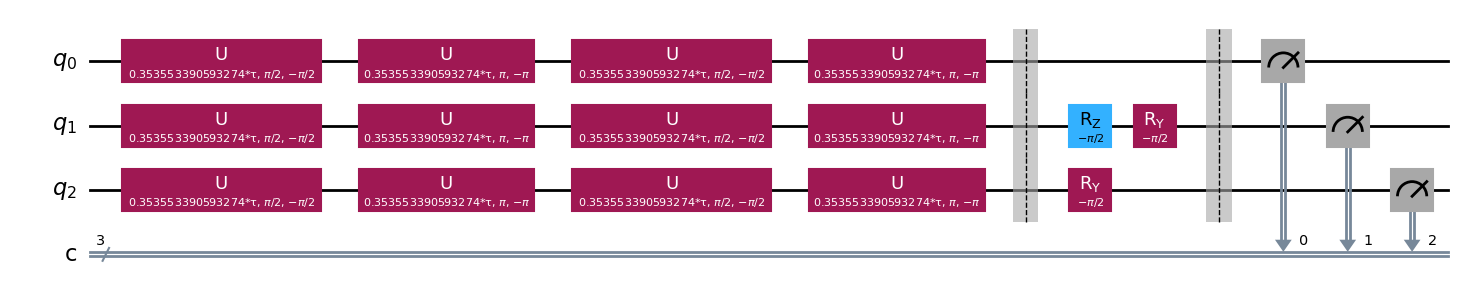

In [ ]:
tau = Parameter('τ')
Nt = 75

tau_range = np.linspace(0, 2*np.pi, Nt)

qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc0 = QuantumCircuit(qr,cr)

#vary this:
ntrot = 2

for i in range(0,ntrot):
    timecirc0.u(tau/(np.sqrt(2)*ntrot),np.pi/2,-np.pi/2,qr)
    timecirc0.u(tau/(np.sqrt(2)*ntrot),np.pi,-np.pi,qr)

timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1)
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw('mpl')

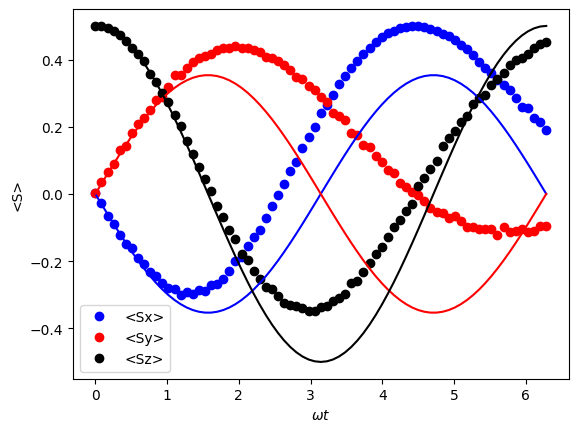

In [ ]:
sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc0, tau_range)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

Sx = np.zeros(Nt)
Sy = np.zeros(Nt)
Sz = np.zeros(Nt)

for n in range(0,Nt):
    simcounts = result.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sx[n] = Sx[n] + 0.5*simcounts[state]/nshots
        else:
            Sx[n] = Sx[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sy[n] = Sy[n] + 0.5*simcounts[state]/nshots
        else:
            Sy[n] = Sy[n] - 0.5*simcounts[state]/nshots

        if (state[2]=='0'):
            Sz[n] = Sz[n] + 0.5*simcounts[state]/nshots
        else:
            Sz[n] = Sz[n] - 0.5*simcounts[state]/nshots

plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()

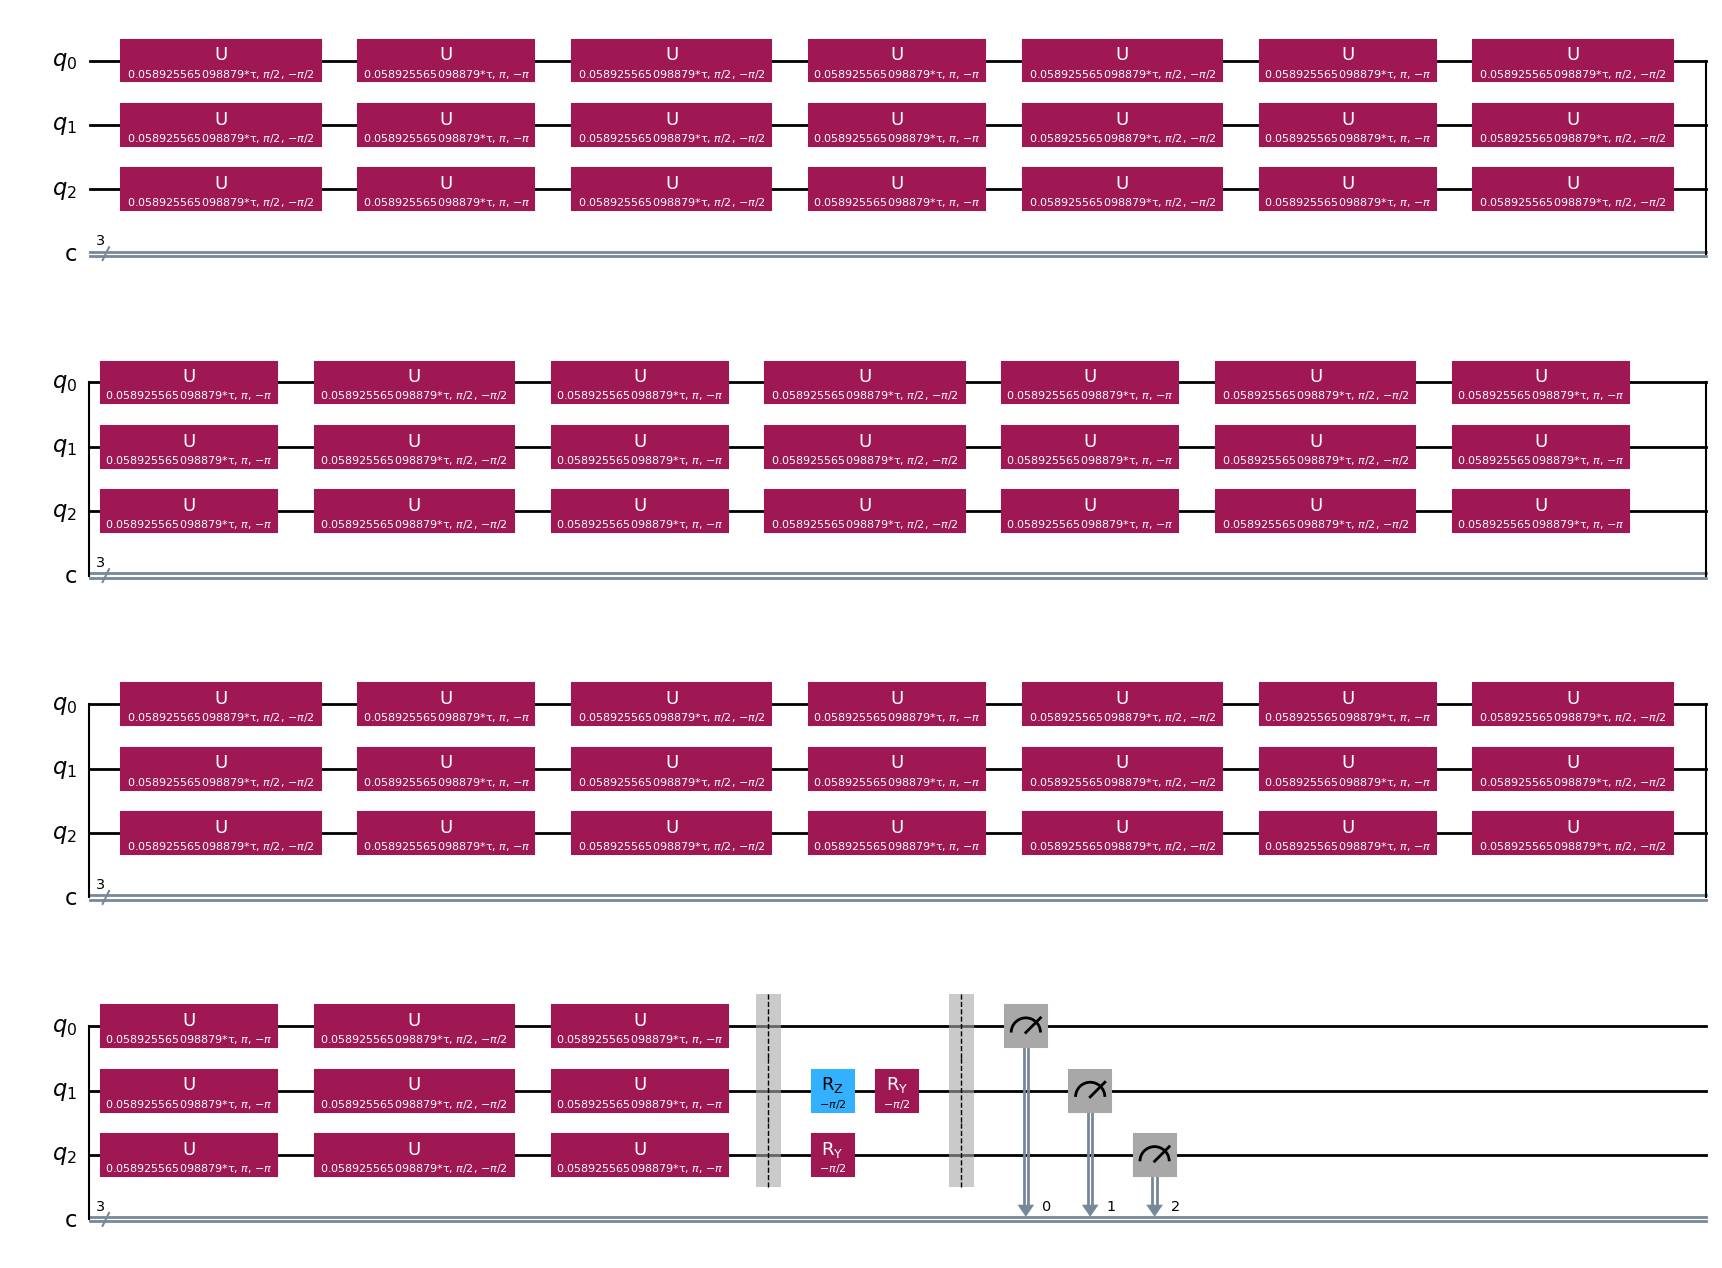

In [ ]:
tau = Parameter('τ')
Nt = 75

tau_range = np.linspace(0, 2*np.pi, Nt)

qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc0 = QuantumCircuit(qr,cr)

#vary this:
ntrot = 12

for i in range(0,ntrot):
    timecirc0.u(tau/(np.sqrt(2)*ntrot),np.pi/2,-np.pi/2,qr)
    timecirc0.u(tau/(np.sqrt(2)*ntrot),np.pi,-np.pi,qr)

timecirc0.barrier(qr)
timecirc0.ry(-np.pi/2,2) #rotation to measure <Sx>

timecirc0.rz(-np.pi/2,1)
timecirc0.ry(-np.pi/2,1) #rotation to measure <Sy>
timecirc0.barrier(qr)
#no rotation needed to measure <Sz>

timecirc0.measure(qr,cr)
timecirc0.draw('mpl')

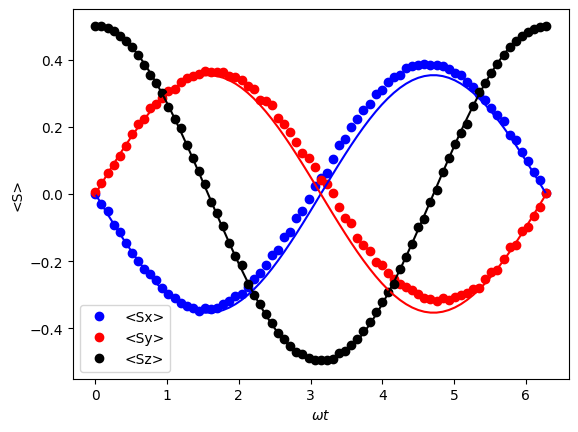

In [ ]:
sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc0, tau_range)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

Sx = np.zeros(Nt)
Sy = np.zeros(Nt)
Sz = np.zeros(Nt)

for n in range(0,Nt):
    simcounts = result.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sx[n] = Sx[n] + 0.5*simcounts[state]/nshots
        else:
            Sx[n] = Sx[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sy[n] = Sy[n] + 0.5*simcounts[state]/nshots
        else:
            Sy[n] = Sy[n] - 0.5*simcounts[state]/nshots

        if (state[2]=='0'):
            Sz[n] = Sz[n] + 0.5*simcounts[state]/nshots
        else:
            Sz[n] = Sz[n] - 0.5*simcounts[state]/nshots

plt.plot(tau_range,Sx,'bo',label='<Sx>')
plt.plot(tau_range,Sy,'ro',label='<Sy>')
plt.plot(tau_range,Sz,'ko',label='<Sz>')
plt.plot(tau_range,0.5*np.cos(3*np.pi/4)*np.sin(tau_range),'b-')
plt.plot(tau_range,0.5*np.sin(3*np.pi/4)*np.sin(tau_range),'r-')
plt.plot(tau_range,0.5*np.cos(tau_range),'k-')
plt.xlabel('$\omega t$')
plt.ylabel('<S>')
plt.legend()
plt.show()